In [46]:
import keras
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D 
from keras.models import Sequential, Model 

import tensorflow.keras as tk
import cv2
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = tk.datasets.cifar10.load_data()

# Select a single class images (birds)
X_train = X_train[y_train.flatten() == 2]

In [48]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

In [49]:
def build_generator():
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [50]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [51]:
!pip install Adam
import adam

In [52]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=tf.optimizers.Adam(0.0002,0.5),
            metrics=['accuracy'])
# Build the generator
generator = build_generator()
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)
# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated images as input and determines validity
valid = discriminator(img)
# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(0.0002,0.5))

In [53]:
def show_imgs(epoch):
    noise = np.random.normal(0, 1, (4 * 4,latent_dim))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,])
            axs[i,j].axis('off')
            cnt += 1
        plt.show()
        plt.close()

In [54]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

2022-01-24 17:24:45.927440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 17:24:46.211043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 17:24:46.655849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0 [D loss: 1.292575] [G loss: 0.787193]


2022-01-24 17:24:46.920669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


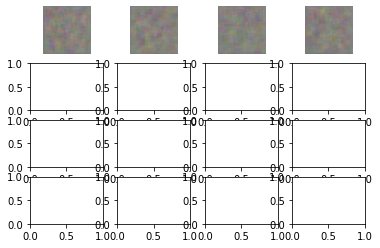

1000 [D loss: -6.371704] [G loss: -0.505228]


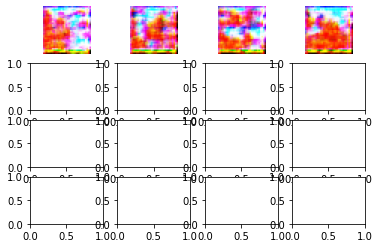

2000 [D loss: -28.636944] [G loss: -3.480673]


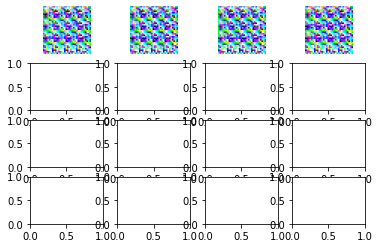

In [ ]:
epochs=15000
batch_size=32
display_interval=1000
losses=[]
#normalizing the input
X_train = X_train / 127.5 - 1.
# Adversarial ground truths
valid = np.ones((batch_size, 1))
#let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)
for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
# Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)
# Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
#  Train Generator
# Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)
            
    # Plot the progress
    if epoch % display_interval==0:
        print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
        show_imgs(epoch)
    if epoch % 100==0:
        losses.append((d_loss[0],g_loss))